In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)  # FutureWarningを消している

In [2]:
import geopandas as gpd
import osmnx as ox

In [3]:
import matplotlib.pyplot as plt

In [4]:
# 渋谷駅（スクランブル交差点）
shibuya_eki = (35.65952515598417, 139.70055390184527)

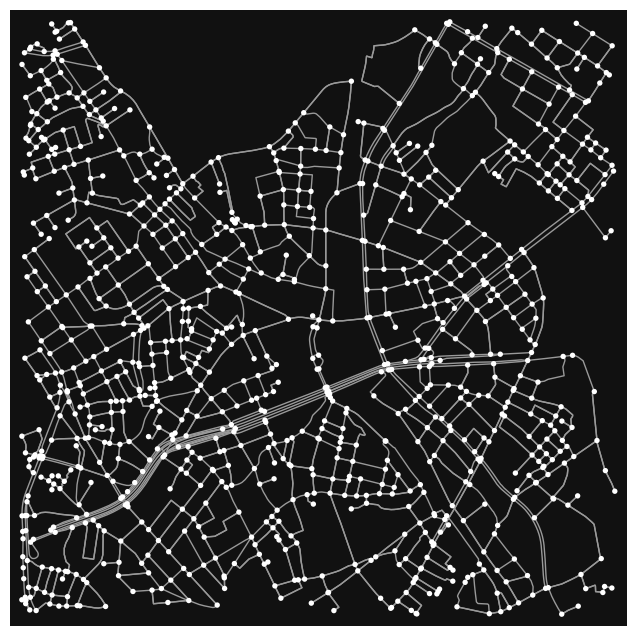

In [13]:
# 半径1000mの地図を表示
dist = 1000  # meters
G = ox.graph_from_point(shibuya_eki, dist, network_type="drive")
fig, ax = ox.plot_graph(G)

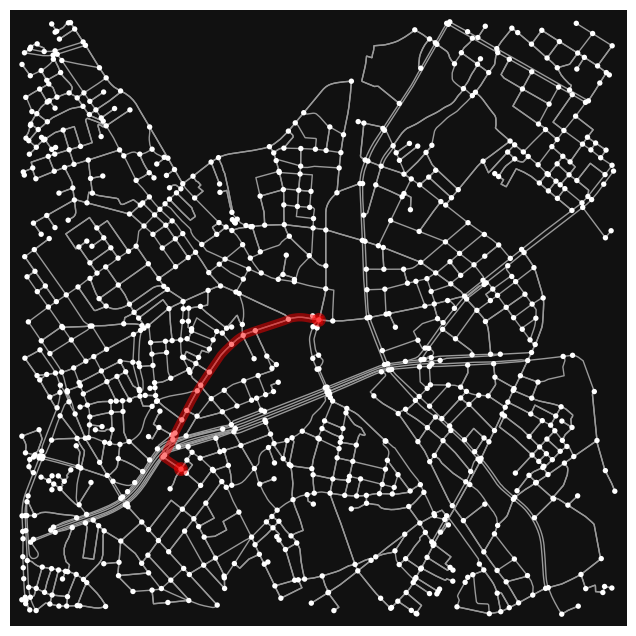

In [14]:
# 渋谷駅からHENGEまでの最短距離
start_node = ox.distance.nearest_nodes(G, shibuya_eki[1], shibuya_eki[0])
end_point = (35.65495728145334, 139.69494603459512)  # HENGE
end_node = ox.distance.nearest_nodes(G, end_point[1], end_point[0])

route = ox.shortest_path(G, start_node, end_node)  # 最短経路を取得
fig, ax = ox.plot_graph_route(G, route, route_color='r', route_linewidth=6) # ルートを表示

In [16]:
# 渋谷駅とHENGEを角とする地図
north, south, east, west = shibuya_eki[0], end_point[0],shibuya_eki[1], end_point[1] 
G = ox.graph_from_bbox(north, south, east, west, network_type='all')

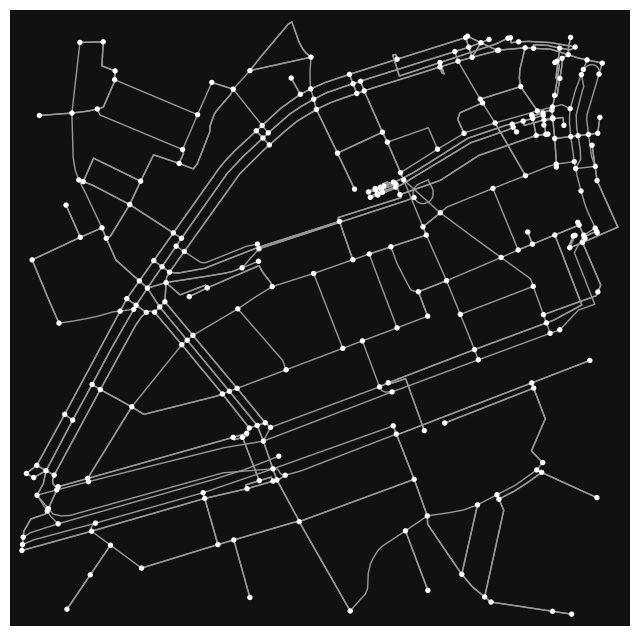

In [17]:
ox.plot_graph(ox.project_graph(G))
plt.show()

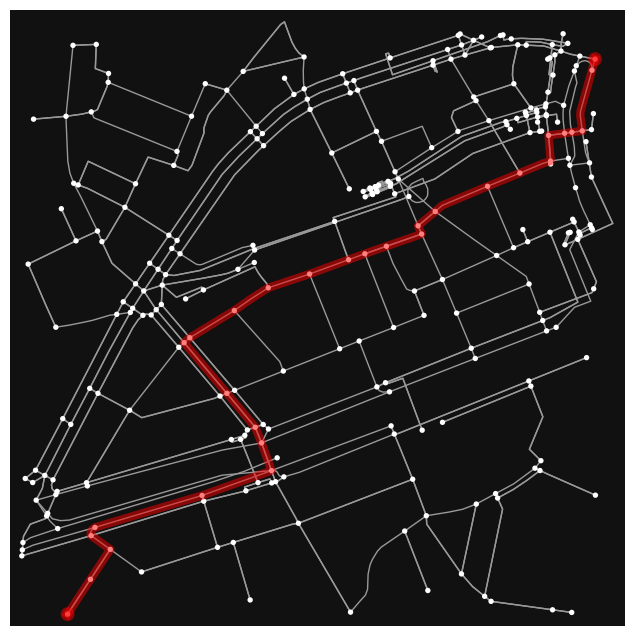

In [18]:
# 渋谷駅からHENGEまでの最短距離
start_node = ox.distance.nearest_nodes(G, shibuya_eki[1], shibuya_eki[0])
end_point = (35.65495728145334, 139.69494603459512)  # HENGE
end_node = ox.distance.nearest_nodes(G, end_point[1], end_point[0])

route = ox.shortest_path(G, start_node, end_node)  # 最短経路を取得
fig, ax = ox.plot_graph_route(G, route, route_color='r', route_linewidth=6) # ルートを表示

In [29]:
list(route)

[291758776,
 252675828,
 356642816,
 598416625,
 1014529837,
 2866946997,
 356644261,
 694150810,
 356644262,
 1014529833,
 356644779,
 381063833,
 625566390,
 748883733,
 748883764]

In [20]:
end_node

748883764

In [23]:
# ノードの緯度・経度を取得
latitude = G.nodes[end_node]['y']
longitude = G.nodes[end_node]['x']

print(f"Node ID {end_node} の緯度: {latitude}, 経度: {longitude}")

Node ID 748883764 の緯度: 35.6549584, 経度: 139.6954255


左折だけで目的地に行くとは、「右折をしない」ということ

* 最短距離を求める
* スタート地点から、1つ目のノードへの角度と2つ目のノードの角度を比較する
* 進行方向を向いて右側にルートある場合は、

方針
ノードの隣接ノードを探索し、進行方向（角度）を計算:

ノード間の進行方向（方位角）を計算し、右折を避けるようにする。
右折の条件を定義:

右折は「進行方向の角度が90度より大きくなる」場合です。進行方向の角度が90度より小さい場合は「左折または直進」になります。
経路探索を行う:

右折を避けるために、隣接ノードを探索する際に、進行方向と角度が90度以上にならないように制約を加えます。

In [16]:
import numpy as np
import math

In [17]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    2点間の方位角（北から時計回りの角度）を計算する関数
    """
    # 緯度・経度をラジアンに変換
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # 経度の差
    delta_lon = lon2 - lon1

    # 方位角の計算
    x = np.sin(delta_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)

    # atan2で方位角を求める（ラジアン）
    bearing = np.degrees(np.arctan2(x, y))

    # 0から360度の範囲に調整
    bearing = (bearing + 360) % 360

    return bearing


In [49]:
def get_straight_or_left_turnable_paths(G, current_node, previous_bearing, max_turn_angle=90):
    """
    右折しない経路を取得する関数（左折または直進のみ）
    """
    neighbors = list(G.neighbors(current_node))
    print("neighbors", neighbors)
    valid_paths = []
    
    for neighbor in neighbors:
        # 現在のノードと隣接ノードの緯度・経度を取得
        lat1, lon1 = G.nodes[current_node]['y'], G.nodes[current_node]['x']
        lat2, lon2 = G.nodes[neighbor]['y'], G.nodes[neighbor]['x']
        
        # ノード間の方位角を計算
        bearing = calculate_bearing(lat1, lon1, lat2, lon2)
        
        # 前回の進行方向との角度差を計算
        turn_angle = (bearing - previous_bearing + 360) % 360
        print("turn_angle", turn_angle)
        
        # 右折が発生しない条件をチェック（例えば、右折は90度以上）
        # if turn_angle >= 0 and turn_angle <= max_turn_angle:
        if turn_angle >= max_turn_angle:
            valid_paths.append(neighbor)
    
    return valid_paths


In [50]:
len(list(route))

15

In [ ]:
# 例: 東京の道路ネットワークを取得
# place_name = "Tokyo, Japan"
# G = ox.graph_from_place(place_name, network_type='all')

# 出発点と目的地のノードを指定（ここでは最初の2つのノードを例に使用）
# start_node = 356644261
# end_node = 291758776

# 出発点の緯度・経度
start_lat, start_lon = G.nodes[start_node]['y'], G.nodes[start_node]['x']

pre_lat = start_lat
pre_lon = start_lon

# 初期進行方向の設定（出発点の進行方向は0度に初期化）
initial_bearing = 0

# 右折しない経路を探索
current_node = start_node
route2 = [current_node]
previous_bearing = initial_bearing

while current_node != end_node:
    # 次のノード（右折しないノード）を取得
    possible_next_nodes = get_straight_or_left_turnable_paths(G, current_node, previous_bearing)
    print("possible_next_nodes", possible_next_nodes)
    
    if not possible_next_nodes:
        print("右折しない経路が見つかりませんでした。")
        break
    
    # 次のノードを選択（最初の候補を選択）
    next_node = possible_next_nodes[-1]
    
    # 次のノードの緯度・経度を取得
    next_lat, next_lon = G.nodes[next_node]['y'], G.nodes[next_node]['x']
    
    # 次のノードの方位角を計算
    previous_bearing = calculate_bearing(pre_lat, pre_lon, next_lat, next_lon)
    print(previous_bearing)
    
    # 経路に追加
    route2.append(next_node)
    print("route2", route2)
    
    # 現在のノードを更新
    current_node = next_node

    pre_lat = next_lat
    pre_lon = next_lon

# 結果の表示
print("右折しない経路: ", route2)


neighbors [5244745709, 9518528864, 1316007410, 252674261, 252675828]
turn_angle 302.4198484914142
turn_angle 192.94778373849897
turn_angle 94.55302328711025
turn_angle 12.298811448711263
turn_angle 271.0978779670469
possible_next_nodes [5244745709, 9518528864, 1316007410, 252675828]
271.0978779670469
route2 [291758776, 252675828]
neighbors [291758776, 356642816, 598416635]
turn_angle 179.99933710839912
turn_angle 340.04234416885316
turn_angle 26.53639876133701
possible_next_nodes [291758776, 356642816]
251.14022213590005
route2 [291758776, 252675828, 356642816]
neighbors [356643555, 598416625, 252675828]
turn_angle 264.5939884480179
turn_angle 357.10832525695594
turn_angle 179.99927893117257
possible_next_nodes [356643555, 598416625, 252675828]
71.13950106707262
route2 [291758776, 252675828, 356642816, 252675828]
neighbors [291758776, 356642816, 598416635]
turn_angle 19.957714008373387
turn_angle 180.0007210688275
turn_angle 226.49477566131122
possible_next_nodes [356642816, 598416635]

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
ox.plot_graph_route(G, route2, route_linewidth=6, node_size=0, bgcolor='k')
plt.show()